In [2]:
import re
from typing import List, Set, cast

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

from utils import ROOTDIR

In [3]:
TRAIN_FILE_PATH = ROOTDIR / "data" / "train_data.csv"
TEST_FILE_PATH = ROOTDIR / "data" / "test_data.csv"

In [4]:
pl.scan_csv(TRAIN_FILE_PATH, truncate_ragged_lines=True).head(5).collect()

id,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,…,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
i64,i64,i64,str,str,f64,i64,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,str
3054,36230,443,"""tcp""","""ssl""",10.644097,15,10,7,5,1.409232,0.939488,2.34872,0.666667,488,32,40,316,20,40,2,2,1,4,4,23,0,0,0,0,0.0,1408.0,5465.0,364.333333,570.83431,0.0,1364.0,…,760292.649269,2.6598e6,48.875809,9.9978e6,1.0640e7,1.1822e6,3.3080e6,1.907349,9.9977e6,1.0708e7,446147.501469,2.0353e6,888.097874,7.5,5.0,2732.5,1994.0,0.0,0.0,0.0,0.0,0.0,0.0,64044.952393,645756.006241,709800.958633,354900.479317,411331.830867,9.9977e6,9.9977e6,9.9977e6,9.9977e6,0.0,64240,26544,501,"""ARP_poisioning"""
3576,57920,443,"""tcp""","""ssl""",1.250508,13,12,3,9,10.395777,9.596101,19.991878,0.923077,400,20,40,392,32,40,2,2,2,3,7,22,0,0,0,0,0.0,517.0,840.0,64.615385,149.358929,0.0,1408.0,…,104403.158,111494.7254,43.869019,320106.9832,1.0319e6,93808.26083,132016.2263,43.869019,240163.0878,1.2528e6,52201.57901,92261.77425,5706.481655,13.0,12.0,840.0,6296.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2528e6,1.2528e6,1.2528e6,1.2528e6,0.0,0.0,0.0,0.0,0.0,0.0,64240,26847,0,"""Thing_Speak"""
74179,62897,21,"""tcp""","""-""",0.000002,1,1,1,0,524288.0,524288.0,1.048576e6,1.0,20,20,20,20,20,20,0,1,1,0,0,1,0,0,0,0,120.0,120.0,120.0,120.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.907349,1.907349,1.907349,1.907349,0.0,6.291456e7,1.0,1.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.907349,1.907349,1.907349,1.907349,0.0,0.0,0.0,0.0,0.0,0.0,64,0,64,"""DOS_SYN_Hping"""
1011,50078,49186,"""udp""","""-""",0.0,1,0,1,0,0.0,0.0,0.0,0.0,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,40.0,40.0,40.0,40.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,"""NMAP_UDP_SCAN"""
74372,27538,21,"""tcp""","""-""",0.000002,1,1,1,0,466033.777778,466033.777778,932067.555556,1.0,20,20,20,20,20,20,0,1,1,0,0,1,0,0,0,0,120.0,120.0,120.0,120.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.145767,2.145767,2.145767,2.145767,0.0,5.5924e7,1.0,1.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.145767,2.145767,2.145767,2.145767,0.0,0.0,0.0,0.0,0.0,0.0,64,0,64,"""DOS_SYN_Hping"""


In [5]:
train_data = pl.scan_csv(TRAIN_FILE_PATH, truncate_ragged_lines=True).collect()
test_data = pl.scan_csv(TEST_FILE_PATH, truncate_ragged_lines=True).collect()

In [6]:
if len(train_data.columns) != len(test_data.columns):
	raise AssertionError(
		f"No. of columns must be the same: train={len(train_data.columns)}, test={len(test_data.columns)}"
	)

In [7]:
if len(set(train_data.columns) - set(test_data.columns)) > 0:
    raise AssertionError("Missing columns in test_data")

if len(set(test_data.columns) - set(train_data.columns)) > 0:
    raise AssertionError("Missing columns in train_data")

In [8]:
(
    [
        column
        for column, nulls in train_data.null_count().to_dict().items()
        if nulls.item() > 0
    ],
    [
        column
        for column, nulls in test_data.null_count().to_dict().items()
        if nulls.item() > 0
    ],
)

([], [])

---

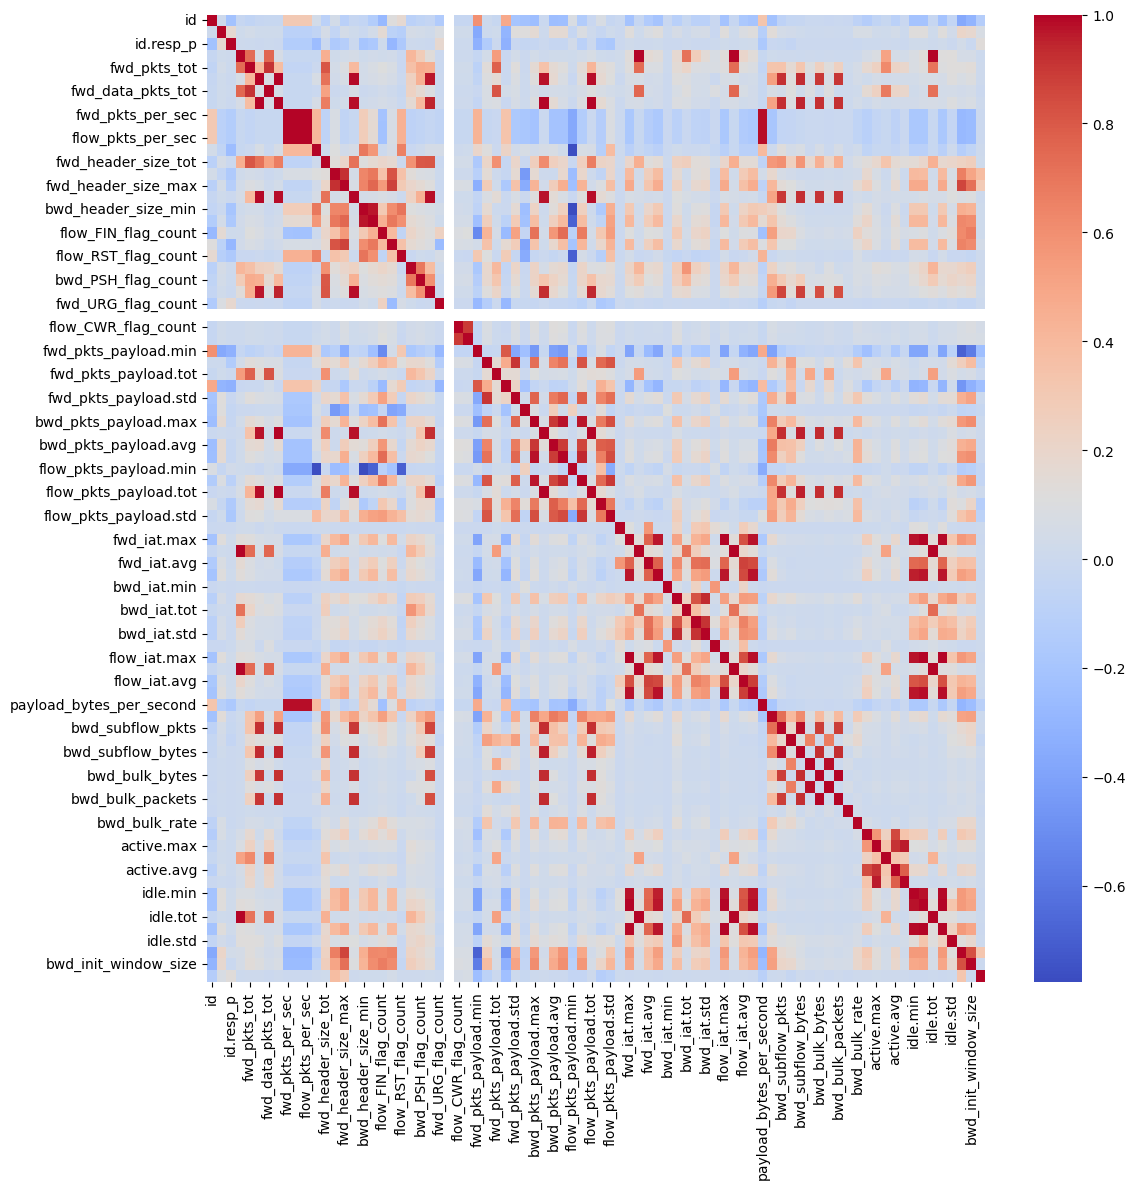

In [13]:
# type: ignore

plt.figure(figsize=(12, 12))
sns.heatmap(
    train_data.select(
        [
            column
            for column, dtype in zip(train_data.columns, train_data.dtypes)
            if dtype in [pl.Int32, pl.Int64, pl.Float32, pl.Float64]
        ]
    )
    .to_pandas()
    .corr(),
    annot=False,
    cmap="coolwarm",
)
plt.tight_layout()

plt.savefig(ROOTDIR / "docs" / "Images" / "correlation_matrix.png")

plt.show()

In [9]:
target_columns: List[str] = ["Attack_type"]

In [10]:
corr_matrix = (
    train_data.select(
        [
            column
            for column, dtype in zip(train_data.columns, train_data.dtypes)
            if dtype in [pl.Int32, pl.Int64, pl.Float32, pl.Float64]
        ]
    )
    .to_pandas()
    .corr()
    .abs()
)

df_train = train_data.drop(
    [
        column
        for column in train_data.columns
        if re.search(r"^id$|^id[._]|[._]id$", column, re.IGNORECASE)
    ]
)

df_test = test_data.drop(
    [
        column
        for column in test_data.columns
        if re.search(r"^id$|^id[._]|[._]id$", column, re.IGNORECASE)
    ]
)

highly_correlated: Set[str] = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if cast(float, corr_matrix.iat[i, j]) > 0.95:
            colname = corr_matrix.columns[j]
            highly_correlated.add(colname)

df_train_raw = df_train.drop(list(highly_correlated)).to_pandas()
df_test_raw = df_test.drop(list(highly_correlated)).to_pandas()

In [11]:
df_train_raw['Attack_type'].value_counts()

Attack_type
DOS_SYN_Hping                 71027
Thing_Speak                    6025
ARP_poisioning                 5883
MQTT_Publish                   3050
NMAP_UDP_SCAN                  1943
NMAP_OS_DETECTION              1515
NMAP_XMAS_TREE_SCAN            1493
NMAP_TCP_scan                   769
DDOS_Slowloris                  404
Wipro_bulb                      188
Metasploit_Brute_Force_SSH       24
NMAP_FIN_SCAN                    16
Name: count, dtype: int64

---

In [12]:
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

In [13]:
X_raw = df_train_raw.drop(target_columns, axis=1)
y_raw = df_train_raw[target_columns].values.ravel()

In [32]:
le = LabelEncoder()

In [33]:
X_encoded = X_raw.copy()
for column in X_encoded.select_dtypes(include="object").columns:
    X_encoded[column] = le.fit_transform(X_encoded[column])

In [34]:
y_encoded = le.fit_transform(y_raw)

In [36]:
TARGET_N = int(df_train_raw[target_columns].value_counts().mean())

In [39]:
# type: ignore

counter = Counter(y_encoded)
major_class_id = max(counter, key=counter.get)

under_strategy = {major_class_id: TARGET_N}
under = RandomUnderSampler(sampling_strategy=under_strategy, random_state=42)
over = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=42)

In [40]:
pipeline = Pipeline(steps=[("under", under), ("over", over)])

In [41]:
X_resampled, y_resampled = pipeline.fit_resample(X_encoded, y_encoded)  # type: ignore

In [42]:
len(X_resampled), len(y_resampled)  # type: ignore

(92328, 92328)

---

In [49]:
from lazypredict.Supervised import LazyClassifier

In [50]:
clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)

In [52]:
# type: ignore

X_train = X_resampled.copy()
y_train = y_resampled.copy()

X_test = df_test_raw.drop(target_columns, axis=1)

for column in X_test.select_dtypes(include="object").columns:
    X_test[column] = le.fit_transform(X_test[column])

y_test = le.fit_transform(df_test_raw[target_columns].values.ravel())

In [53]:
# type: ignore

models, predictions = clf.fit(
    X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
)

  0%|          | 0/32 [00:00<?, ?it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.17738791423001948, 'Balanced Accuracy': 0.6949191087689858, 'ROC AUC': None, 'F1 Score': 0.16896079410470471, 'Time taken': 10.209028720855713}
{'Model': 'BaggingClassifier', 'Accuracy': 0.9969135802469136, 'Balanced Accuracy': 0.9473833314798634, 'ROC AUC': None, 'F1 Score': 0.9969034341346354, 'Time taken': 11.025483846664429}
{'Model': 'BernoulliNB', 'Accuracy': 0.8382472384665367, 'Balanced Accuracy': 0.8010674045103148, 'ROC AUC': None, 'F1 Score': 0.8693999006654834, 'Time taken': 0.3568282127380371}


d:\dev\python\rt-iot\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\dev\python\rt-iot\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\dev\python\rt-iot\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\dev\python\rt-iot\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\dev\python\rt-iot\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.9839181286549707, 'Balanced Accuracy': 0.9244496140482061, 'ROC AUC': None, 'F1 Score': 0.9843128128354401, 'Time taken': 963.1326127052307}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.9967105263157895, 'Balanced Accuracy': 0.9332095440853238, 'ROC AUC': None, 'F1 Score': 0.9966813203699314, 'Time taken': 1.734400749206543}
{'Model': 'DummyClassifier', 'Accuracy': 0.06042884990253411, 'Balanced Accuracy': 0.08333333333333333, 'ROC AUC': None, 'F1 Score': 0.0068871115697741086, 'Time taken': 0.22034168243408203}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.9959795321637427, 'Balanced Accuracy': 0.9403049362274362, 'ROC AUC': None, 'F1 Score': 0.9959842223599751, 'Time taken': 0.25678253173828125}
{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.9972384665367121, 'Balanced Accuracy': 0.9493857293130886, 'ROC AUC': None, 'F1 Score': 0.9972256350474028, 'Time taken': 3.613084316253662}
{'Model': 'GaussianNB', 'Accuracy': 0.9152452891

d:\dev\python\rt-iot\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'Model': 'LinearSVC', 'Accuracy': 0.9796946068875894, 'Balanced Accuracy': 0.9186129151406245, 'ROC AUC': None, 'F1 Score': 0.9800011786235956, 'Time taken': 217.99678778648376}


d:\dev\python\rt-iot\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Model': 'LogisticRegression', 'Accuracy': 0.9846085120207927, 'Balanced Accuracy': 0.928738944183611, 'ROC AUC': None, 'F1 Score': 0.9849851525440458, 'Time taken': 3.0480096340179443}


d:\dev\python\rt-iot\.venv\Lib\site-packages\sklearn\neighbors\_nearest_centroid.py:244: UserWarning: self.within_class_std_dev_ has at least 1 zero standard deviation.Inputs within the same classes for at least 1 feature are identical.
  warnings.warn(


{'Model': 'NearestCentroid', 'Accuracy': 0.8905945419103314, 'Balanced Accuracy': 0.7494841038595218, 'ROC AUC': None, 'F1 Score': 0.8845264142778491, 'Time taken': 0.2875025272369385}
{'Model': 'NuSVC', 'Accuracy': 0.8749593892137751, 'Balanced Accuracy': 0.8678277990382619, 'ROC AUC': None, 'F1 Score': 0.895430634710881, 'Time taken': 840.2497365474701}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.9853395061728395, 'Balanced Accuracy': 0.9147254460069641, 'ROC AUC': None, 'F1 Score': 0.9856527476792943, 'Time taken': 3.190864086151123}
{'Model': 'Perceptron', 'Accuracy': 0.9723034437946718, 'Balanced Accuracy': 0.8965404088454768, 'ROC AUC': None, 'F1 Score': 0.9716459159495511, 'Time taken': 3.833484411239624}


d:\dev\python\rt-iot\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
d:\dev\python\rt-iot\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
d:\dev\python\rt-iot\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
d:\dev\python\rt-iot\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.wa

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.9661306042884991, 'Balanced Accuracy': 0.8815411883891424, 'ROC AUC': None, 'F1 Score': 0.9657271562200093, 'Time taken': 0.7349264621734619}
{'Model': 'RandomForestClassifier', 'Accuracy': 0.9973196881091618, 'Balanced Accuracy': 0.9500605806920898, 'ROC AUC': None, 'F1 Score': 0.9973151997853422, 'Time taken': 12.236685752868652}
{'Model': 'RidgeClassifier', 'Accuracy': 0.9481400259909032, 'Balanced Accuracy': 0.8687324364631629, 'ROC AUC': None, 'F1 Score': 0.943243218147581, 'Time taken': 0.35129809379577637}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.9481400259909032, 'Balanced Accuracy': 0.8687324364631629, 'ROC AUC': None, 'F1 Score': 0.943243218147581, 'Time taken': 0.9384052753448486}
{'Model': 'SGDClassifier', 'Accuracy': 0.9833901884340481, 'Balanced Accuracy': 0.9252172952385154, 'ROC AUC': None, 'F1 Score': 0.9842565556351708, 'Time taken': 4.134959697723389}
{'Model': 'SVC', 'Accuracy': 0.99317738791423, 'Balanced

d:\dev\python\rt-iot\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


{'Model': 'LGBMClassifier', 'Accuracy': 0.997279077322937, 'Balanced Accuracy': 0.9515432357597634, 'ROC AUC': None, 'F1 Score': 0.9972709249995767, 'Time taken': 8.195882797241211}


In [55]:
models[models['Balanced Accuracy'] > 0.9]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,1.00,0.95,None,1.00,5.79
LGBMClassifier,1.00,0.95,None,1.00,8.20
RandomForestClassifier,1.00,0.95,None,1.00,12.24
ExtraTreesClassifier,1.00,0.95,None,1.00,3.61
BaggingClassifier,1.00,0.95,None,1.00,11.03
ExtraTreeClassifier,1.00,0.94,None,1.00,0.26
SVC,0.99,0.94,None,0.99,29.54
KNeighborsClassifier,0.99,0.93,None,0.99,3.00
DecisionTreeClassifier,1.00,0.93,None,1.00,1.73


---

In [67]:
# type: ignore

import joblib
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [57]:
model = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [58]:
model.fit(X_train, y_train)  # type: ignore

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [59]:
y_pred = model.predict(X_test)

<Figure size 1200x1200 with 0 Axes>

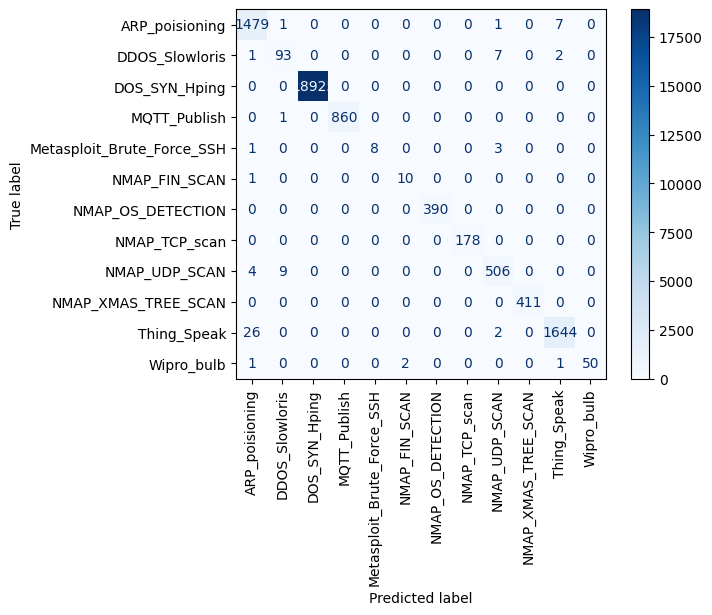

In [62]:
# type: ignore

plt.figure(figsize=(12, 12))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues', values_format='d')
plt.show()

In [66]:
feat_importances = pd.Series(model.feature_importances_, index=X_encoded.columns)
feat_importances.nlargest(10)

service                0.07
fwd_URG_flag_count     0.07
fwd_header_size_min    0.07
bwd_header_size_min    0.05
flow_FIN_flag_count    0.05
bwd_init_window_size   0.04
fwd_header_size_max    0.04
fwd_init_window_size   0.04
fwd_pkts_payload.max   0.04
fwd_pkts_payload.min   0.03
dtype: float64

In [ ]:
EXPORT_PATH = ROOTDIR / "models" / "ExtraTreesClassifier.joblib"
EXPORT_PATH.parent.mkdir(parents=True, exist_ok=True)

joblib.dump(model, EXPORT_PATH)  # type: ignore

['d:\\dev\\python\\rt-iot\\models\\ExtraTreesClassifier.joblib']